In [ ]:
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd './gdrive/MyDrive/Colab Notebooks/DL-ROMs/brain_damage'

/content/gdrive/MyDrive/Colab Notebooks/DL-ROMs/brain_damage


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Domain and mesh definition
loop = lambda v: np.concatenate((v, v[[0]]))
brain = np.load("brainshape.npz")
domain = fe.polygon(loop(brain["main"][::9])) - fe.polygon(loop(brain["hole1"][::9])) - fe.polygon(loop(brain["hole2"][::8]))
mesh_H = fe.mesh(domain, stepsize=0.02) # high-fidelity (LEAVE AS IS)
mesh_C = fe.loadmesh("./brain-meshes/brain-mesh30.xml") # low-fidelity

h_H = mesh_H.hmax()
print(f"Stepsize fine mesh: {h_H:.5f}")
h_C = mesh_C.hmax()
print(f"Stepsize coarse mesh: {h_C:.5f}")

space_H = fe.space(mesh_H, 'CG', 1)
space_C = fe.space(mesh_C, 'CG', 1)

nh_H = space_H.dim() # nh = 3378 instead of 2414 (high-fidelity)
print("High-fidelity space dimension:", nh_H)
nh_C = space_C.dim()
print("Low-fidelity space dimension:", nh_C)

Stepsize fine mesh: 0.02269
Stepsize coarse mesh: 0.02853
High-fidelity space dimension: 3378
Low-fidelity space dimension: 1490


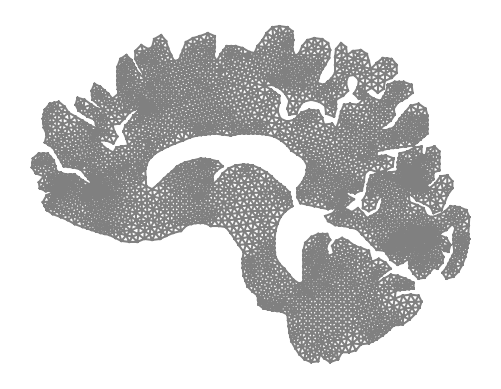

In [ ]:
fe.plot(mesh_H)

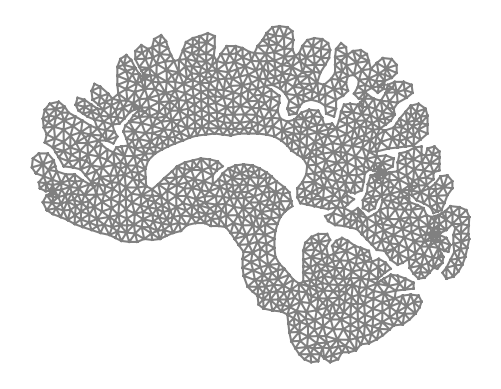

In [ ]:
fe.plot(mesh_C)

In [ ]:
# Set mode
mode = 'h2c'
# 'low': (mu, u) both low fidelity
# 'high': (mu, u) both high fidelity
# 'h2c': high-fidelity mu (sampled from the Gaussian random field), low-fidelity u (computed recovery time)

In [ ]:
# Modeling the initial condition

from geogp import GaussianRandomField
import time

if mode == 'high' or mode == 'h2c':
  start = time.time()
  G_H = GaussianRandomField(domain, mesh_H, kernel = lambda r: np.exp(-100 * r ** 2), upto=30, geoaccuracy=1)
  u0_H = lambda seed: 0.5 * np.tanh(10 * (G_H.sample(seed) + 0.5)) + 0.5
  print("High-fidelity random field, elapsed time:", time.time() - start)

if mode == 'low' or mode == 'h2c':
  G_C = GaussianRandomField(domain, mesh_C, kernel = lambda r: np.exp(-100 * r ** 2), upto=30, geoaccuracy=1)
  u0_C = lambda seed: 0.5 * np.tanh(10 * (G_C.sample(seed) + 0.5)) + 0.5
  print("Low-fidelity random field, elapsed time:", time.time() - start)

Low-fidelity random field, elapsed time: 118.40771985054016


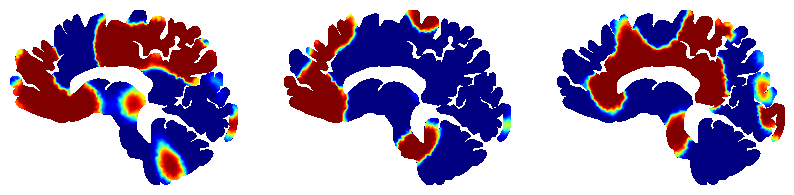

In [ ]:
# Examples of random initial conditions

# NB: dolfin has some issues when plotting functions that are "locally" constant. Thus, it may happen that
# some regions are not plotted at all (as if they were missing o contained nan values). To fix this, one can
# force dolfin to plot a constant background.

if mode == 'high' or mode == 'h2c':
  plt.figure(figsize=(10, 3))
  for seed in [1, 2, 3]:
    plt.subplot(1, 3, seed)
    damage = u0_H(seed)
    fe.plot(1 + 0 * damage, space_H, cmap='jet_r', vmin=0, vmax=1) # fixes the plot by putting a "blue layer" behind it.
    fe.plot(damage, space_H, cmap='jet_r') # actual plot

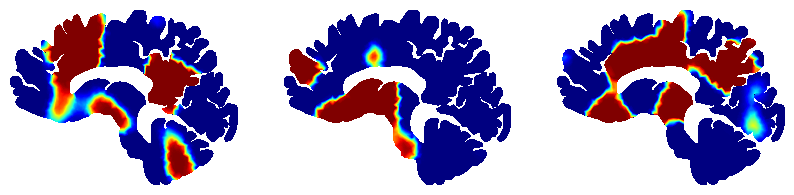

In [ ]:
if mode == 'low' or mode == 'h2c':
  plt.figure(figsize=(10, 3))
  for seed in [1, 2, 3]:
    plt.subplot(1, 3, seed)
    damage = u0_C(seed)
    fe.plot(1 + 0 * damage, space_C, cmap='jet_r', vmin=0, vmax=1) # fixes the plot by putting a "blue layer" behind it.
    fe.plot(damage, space_C, cmap='jet_r') # actual plot

In [ ]:
# Modeling of the damage recovery via FKPP
from fenics import TrialFunction, TestFunction, Function, inner, grad, solve, DirichletBC, Constant, ds, dx, assemble
nt = 200
D = 0.1
r = 1000
dt = 0.0001

# Time iterator
def step(w):

    if mode == 'low' or mode == 'h2c':
      space = space_C
    elif mode == 'high':
      space = space_H

    Z, V = Function(space), TestFunction(space)
    W = fe.asvector(w, space) # Given a vector of dof values, returns the corresponding object in the functional space.
    L = inner(Z, V) * dx  - inner(W, V) * dx + dt * D * inner(grad(Z), grad(V)) * dx # Z = u^(n+1), W = u^n
    L = L - dt * r * inner(Z * (1 - Z), V) * dx
    Z.vector()[:] = w
    solve(L == 0, Z)

    return np.clip(Z.vector()[:], 0, 1)

# Solves the PDE
def pdesample(seed):

    if mode == 'low' or mode == 'h2c':
      nh, u0 = nh_C, u0_C
    elif mode == 'high':
      nh, u0 = nh_H, u0_H

    np.random.seed(seed)
    u = np.zeros((nt, nh))
    u[0] = u0(seed)
    for i in range(nt-1):
        u[i+1] = step(u[i])

    return u

# Samples a pair (mu, u) = (initial_condition, time-to-recovery-map)
def sample(seed):

    if mode == 'low':
      u0 = u0_C
    elif mode == 'high' or mode == 'h2c':
      u0 = u0_H

    mu = u0(seed)
    sol = pdesample(seed)
    u = np.argmax(sol >= 0.9, axis = 0) / nt
    if(np.any(sol.max(axis = 0) < 0.9)):
        # it may happen that the final time was not enough for the brain to fully recover. If so, we try another simulation
        return sample(seed + 50000)
    else:
        return mu, u

In [ ]:
# Sampling and storing of multiple snapshots (via the function dlroms.roms.snapshots)
snapshots(n=900, sampler=sample, verbose=True, filename="snapshots_train_H2C_30.npz")

# NB: the data are generated by letting seed = 0, 1,..., n-1. If you need to generate data in multiple runs,
# be sure to modify the "sampler" definition (e.g. with "sampler2 = lambda seed: sampler(seed+1000)").
# Otherwise, calling snapshots(n = 5, ...) will always produce the same 5 snapshots.

Snapshots generated. Elapsed time: 1 hours 7 minutes 41.72 seconds.


In [ ]:
# Sample data for testing with a different sampler
sample2 = lambda seed: sample(seed + 1000)
snapshots(n=100, sampler=sample2, verbose=True, filename="snapshots_test.npz")

Snapshots generated. Elapsed time: 15 minutes 46.85 seconds.


In [ ]:
# Loading the training snapshots for later use
device = CPU
data = np.load("snapshots_train.npz")
mu, u = device.tensor(data['mu']), device.tensor(data['u'])

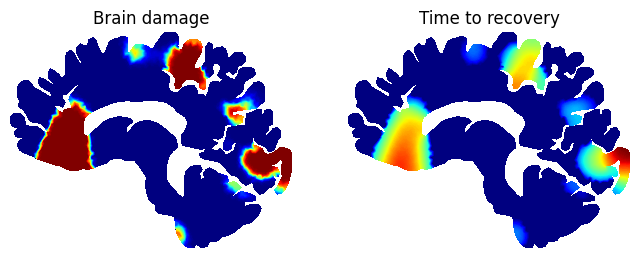

In [ ]:
which = 4
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu[which], space, cmap='jet_r', vmin=0, vmax=1) # fixes the plot by putting a "blue layer" behind it.
fe.plot(mu[which], space, cmap='jet_r')
plt.subplot(1, 2, 2)
plt.title("Time to recovery")
fe.plot(u[which], space, cmap='jet')

In [ ]:
# Loading the test snapshots for later use
device = CPU
data = np.load("snapshots_test.npz")
mu, u = device.tensor(data['mu']), device.tensor(data['u'])

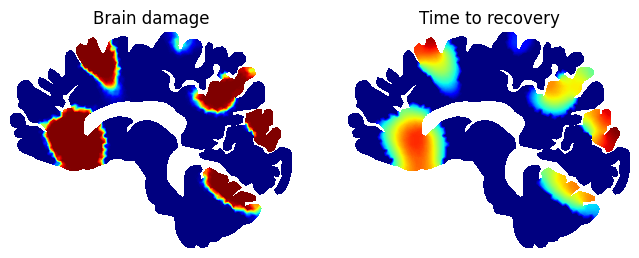

In [ ]:
which = 4
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu[which], space, cmap='jet_r', vmin=0, vmax=1) # fixes the plot by putting a "blue layer" behind it.
fe.plot(mu[which], space, cmap='jet_r')
plt.subplot(1, 2, 2)
plt.title("Time to recovery")
fe.plot(u[which], space, cmap='jet')